# ALD Exploration

In [2]:
%load_ext autoreload
%autoreload 2

## Loading data

In [3]:
import pandas as pd
import os
import numpy as np
import sklearn
import sklearn.linear_model as skllm
import sklearn.ensemble as skle
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
FOLDER_DATA_RAW = 'data/raw'
DATAFOLDER = 'processed/ML'

annotation_file = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'Experiment annotation file.csv'), index_col = [0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_plasma.index = pd.Index(annotation_file_plasma.index, dtype=int)

report_plasma = pd.read_csv(os.path.join(FOLDER_DATA_RAW, '20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv'), na_values='Filtered' )
report_plasma.rename({'PG.Genes': 'Gene names', 'PG.ProteinAccessions': 'Protein ID'}, inplace= True, axis=1)
report_plasma.head()
columns_ = ['Protein ID', 'Gene names']
ids_ = report_plasma[columns_].apply(lambda series_: series_.str.split(';'))

experimental_columns = annotation_file_plasma['Sample ID']
report_plasma[columns_] = report_plasma[columns_].apply(lambda series_: series_.str.split(';').str[0])
map_filenames_ids = dict(zip(annotation_file['File name'], annotation_file['Sample ID']))

data_plasma_raw = report_plasma.copy()
data_plasma_raw.drop(data_plasma_raw.filter(regex='StrippedSequences').columns, axis=1, inplace = True)

data_plasma_raw = data_plasma_raw.rename(mapper = map_filenames_ids, axis=1)
IDmapping_UniprotID_to_Genename = dict(zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))
data_plasma_raw = data_plasma_raw.set_index('Protein ID').drop('Gene names', axis = 1)

key_ProteinID = pd.read_csv(os.path.join(DATAFOLDER, 'ID_matching_key.csv'), 
                            index_col="Protein ID").drop("Unnamed: 0", axis=1)

### Clinical Data

In [5]:
DATAFOLDER = 'processed/ML'
PROTEOM  = 'data_ml_proteomics.csv'
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'
f_data_clinic = os.path.join(DATAFOLDER, CLINICAL)
data_cli = pd.read_csv(f_data_clinic, index_col=COL_ID)
data_cli = data_cli[data_cli['kleiner']!=0.5]

FEATURES_ML = ['nas_steatosis_ordinal', 'nas_inflam', 'kleiner', 
          'fib4', 'elf', 'ft', 'te', 'swe', 'aar','ast',
          'apri','forns','m30', 'm65', 'meld', 'p3np', 'timp1', 'cap' ]

file_cutoff_clinic = "data/raw/clinical_marker_test_cut-offs.xlsx"
cutoffs_clinic = pd.read_excel(file_cutoff_clinic, sheet_name="cutoffs", index_col='marker')

markers_to_drop = []
for marker in cutoffs_clinic.index:
    if marker not in data_cli.columns:
        print(f"{marker}: Missing in clinics data.")
        markers_to_drop.append(marker)
        
if markers_to_drop:
    cutoffs_clinic.drop(labels=markers_to_drop, inplace=True)
cutoffs_clinic

proc3: Missing in clinics data.


,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


## Preprocessing

In [6]:
from helper import log2, imputation_normal_distribution

DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS = 200
CV_COEFFICIENT = 0.3

data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)

qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

cv_selected = proteins_cv < CV_COEFFICIENT

df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30

## Targets

In [7]:
from helper import create_dichotome

target_columns = ['kleiner', 'nas_steatosis_ordinal', 'nas_inflam']
Y = data_cli[target_columns]

kleiner_ge_2 = create_dichotome(Y['kleiner'], 2)
kleiner_ge_3 = create_dichotome(Y['kleiner'], 3)
steatosis_ge_1 = create_dichotome(Y['nas_steatosis_ordinal'], 1)
inflamation_ge_2 = create_dichotome(Y['nas_inflam'], 2)

## Feature Selection

In [8]:
from helper import FeatureSelector

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')

## Cross Validation of Model

In [9]:
test_cases = {}

test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
CV_FOLDS = 5
CV_REPEATS = 10

_clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

proteins_selected = proteins_selected_f2
y = kleiner_ge_2

_X = data_proteomics[proteins_selected.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

In [11]:
# Make sure the results are similar to the previous results

refvals = {}
refvals['test_precision'] = 0.832388
refvals['test_recall'] = 0.788949
refvals['test_f1'] = 0.808201
refvals['test_balanced_accuracy'] = 0.793597
refvals['test_roc_auc'] = 0.884170

mean_vals = np.round(pd.DataFrame(result).mean().to_frame().T, 3)

for key in refvals.keys():
    assert np.round(refvals[key],3) == mean_vals[key][0]


## Check Model
Is there a model that outperforms logistic regression out of the box?

In [13]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [17]:
## Try multiple optimizers and see what happens
results_classifier_comparison = os.path.join(DATAFOLDER, 'results_classifier_comparison.pkl')

try:
   grouped = pd.read_pickle(results_classifier_comparison)
except FileNotFoundError:

    from tqdm.notebook import tqdm as tqdm

    from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
    from xgboost import XGBClassifier

    MLA = [
        #Ensemble Methods
        ensemble.AdaBoostClassifier(),
        ensemble.BaggingClassifier(),
        ensemble.ExtraTreesClassifier(),
        ensemble.GradientBoostingClassifier(),
        ensemble.RandomForestClassifier(),

        #Gaussian Processes
        gaussian_process.GaussianProcessClassifier(),

        #GLM
        linear_model.LogisticRegressionCV(),
        linear_model.PassiveAggressiveClassifier(),
        linear_model.RidgeClassifierCV(),
        linear_model.SGDClassifier(),
        linear_model.Perceptron(),

        #Navies Bayes
        naive_bayes.BernoulliNB(),
        naive_bayes.GaussianNB(),

        #Nearest Neighbor
        neighbors.KNeighborsClassifier(),

        #SVM
        svm.SVC(probability=True),
        svm.NuSVC(probability=True),
        svm.LinearSVC(),

        #Trees    
        tree.DecisionTreeClassifier(),
        tree.ExtraTreeClassifier(),

        #Discriminant Analysis
        discriminant_analysis.LinearDiscriminantAnalysis(),
        discriminant_analysis.QuadraticDiscriminantAnalysis(),


        #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
        XGBClassifier()    
        ]

    summary = []


    for model in tqdm(MLA):

        for test_case in test_cases.keys():

            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']

            _X = data_proteomics[proteins_selected.index]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]

            result = cross_validate(model, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)
            result['name'] = model.__class__.__name__
            result['test_case'] = test_case

            summary.append(pd.DataFrame(result))

    print('Complete')
    summary_df = pd.concat(summary)
    grouped = summary_df.groupby(['name','test_case']).mean().sort_values(by=['test_case','test_f1'], ascending=False)
    grouped = grouped.reset_index()

    grouped.to_pickle(results_classifier_comparison)
grouped

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
0,RidgeClassifierCV,S1,0.005093,0.008647,0.799308,0.849385,0.822579,0.787477,0.857775
1,LinearDiscriminantAnalysis,S1,0.003221,0.006961,0.801652,0.844756,0.821583,0.788056,0.858158
2,LogisticRegressionCV,S1,0.452884,0.005740,0.794931,0.840128,0.815356,0.779569,0.855862
3,SVC,S1,0.009375,0.005403,0.788848,0.816256,0.801156,0.767623,0.844418
4,NuSVC,S1,0.011425,0.005394,0.794314,0.810077,0.800942,0.770361,0.843495
...,...,...,...,...,...,...,...,...,...
83,SGDClassifier,F2,0.003940,0.008081,0.830015,0.730372,0.733233,0.719148,0.884765
84,ExtraTreeClassifier,F2,0.001626,0.004829,0.738093,0.730564,0.731989,0.700191,0.700191
85,LinearSVC,F2,0.013681,0.005099,0.845833,0.690821,0.717678,0.723223,0.883200
86,BernoulliNB,F2,0.001981,0.005361,0.555869,1.000000,0.714534,0.500000,0.500000


## Define a baseline: Logistic Regression

In [18]:
baseline = {}

for test_case in test_cases.keys():
    baseline[test_case] = grouped[(grouped['name'] == 'LogisticRegressionCV') & (grouped['test_case'] == test_case)].iloc[0]

cols = ['fit_time','score_time','test_precision','test_recall','test_f1','test_balanced_accuracy','test_roc_auc']

In [19]:
grouped_norm = grouped.copy()

for i in range(len(grouped)):
    
    grouped_norm.loc[i, cols] -= baseline[grouped_norm.loc[i,'test_case']][cols]

## Best performing algorithms: F1, AUC

In [20]:
grouped_norm.sort_values(by='test_f1', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
44,GaussianNB,F3,-0.566326,-0.001883,-0.033582,0.112807,0.045114,0.044894,-0.011476
66,ExtraTreesClassifier,F2,-0.597898,0.016276,0.013919,0.001526,0.007478,0.010188,0.007651
0,RidgeClassifierCV,S1,-0.447790,0.002907,0.004376,0.009256,0.007223,0.007908,0.001912
22,LogisticRegressionCV,I2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
grouped_norm.sort_values(by='test_roc_auc', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
66,ExtraTreesClassifier,F2,-0.597898,0.016276,0.013919,0.001526,0.007478,0.010188,0.007651
5,RandomForestClassifier,S1,-0.272447,0.020099,0.010702,-0.052474,-0.020261,-0.008108,0.004510
47,RidgeClassifierCV,F3,-0.564109,-0.000460,0.011337,0.008246,0.010894,0.006387,0.002974
25,SVC,I2,-0.379095,0.000017,0.026992,-0.039872,-0.009077,0.004515,0.001264


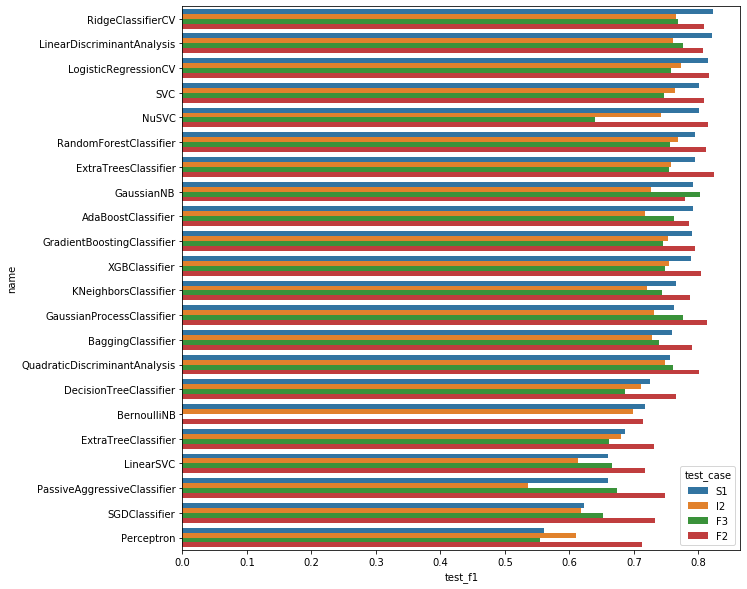

In [22]:
plt.figure(figsize = (10,10))
sns.barplot(x='test_f1', y='name', hue='test_case', data=grouped)
plt.show()

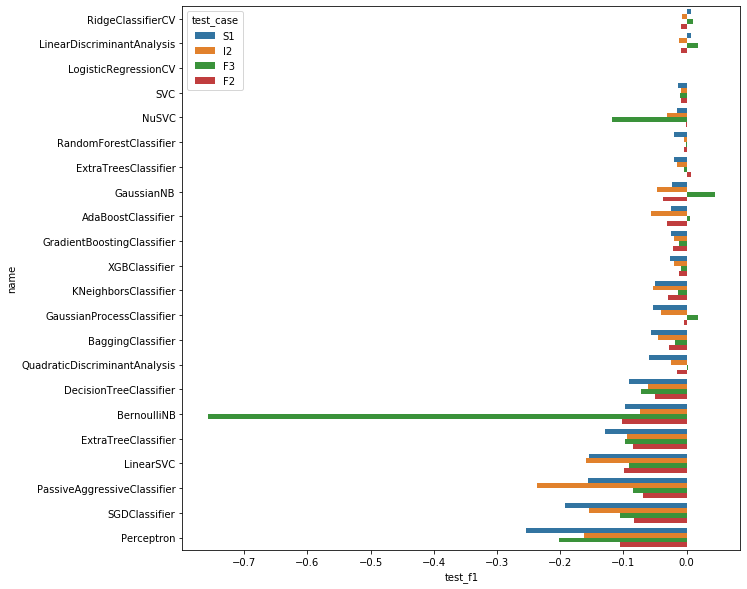

In [23]:
plt.figure(figsize = (10,10))
sns.barplot(x='test_f1', y='name', hue='test_case', data=grouped_norm)
plt.show()

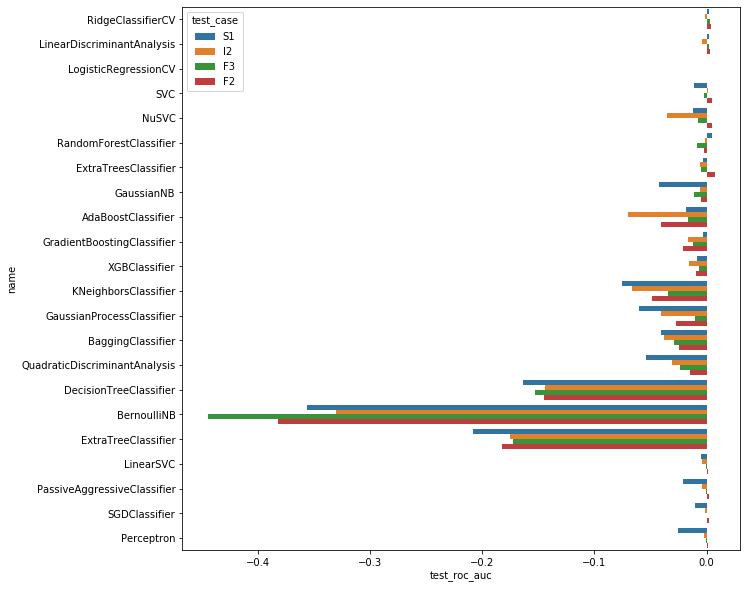

In [24]:
plt.figure(figsize = (10,10))
sns.barplot(x='test_roc_auc', y='name', hue='test_case', data=grouped_norm)
plt.show()

## Can we optimize on the feature selection part?

Let's try a couple of things here: Are the numbers of features optimized?

In [30]:
try:
    summary = pd.read_pickle(feature_selection_comparison_cv)
    feature_selection_comparison_cv = os.path.join(DATAFOLDER, 'feature_selection_comparison_cv.pkl')
except FileNotFoundError:
    summary = []

    for n_features in tqdm(range(1,50)):

        feature_selected = FeatureSelector(k=n_features, protein_gene_data=key_ProteinID)
        proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
        proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
        proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
        proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')

        test_cases = {}

        test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
        test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
        test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
        test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}

        for test_case in test_cases.keys():
            _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']

            _X = data_proteomics[proteins_selected.index]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]

            result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

            result['name'] = _clf.__class__.__name__
            result['n_features'] = n_features
            result['test_case'] = test_case

            summary.append(pd.DataFrame(result))
        
    summary = pd.concat(summary)
    summary.to_pickle(feature_selection_comparison_cv)

In [34]:
summary

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,name,n_features,test_case
0,0.001999,0.004967,0.582090,0.975000,0.728972,0.550000,0.861719,LogisticRegression,1,F2
1,0.003026,0.003972,0.606061,1.000000,0.754717,0.593750,0.822656,LogisticRegression,1,F2
2,0.001004,0.004997,0.565217,0.975000,0.715596,0.518750,0.826563,LogisticRegression,1,F2
3,0.000994,0.005001,0.571429,1.000000,0.727273,0.516129,0.908065,LogisticRegression,1,F2
4,0.000991,0.005012,0.573529,1.000000,0.728972,0.546875,0.927885,LogisticRegression,1,F2
...,...,...,...,...,...,...,...,...,...,...
45,0.003997,0.005003,0.783784,0.783784,0.783784,0.770680,0.899263,LogisticRegression,49,I2
46,0.004999,0.004999,0.690476,0.783784,0.734177,0.694922,0.762490,LogisticRegression,49,I2
47,0.005002,0.005003,0.789474,0.789474,0.789474,0.769737,0.826480,LogisticRegression,49,I2
48,0.004008,0.004961,0.718750,0.605263,0.657143,0.662007,0.755757,LogisticRegression,49,I2


In [36]:
combined = summary.groupby(['test_case', 'n_features']).mean()

combined.sort_values(by='test_f1', ascending=False).groupby('test_case').head(1)

,,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
test_case,n_features,,,,,,,
S1,36,0.003818,0.005379,0.835592,0.834154,0.833322,0.810410,0.890522
F3,21,0.003165,0.005384,0.878523,0.788012,0.828084,0.874383,0.961464
F2,14,0.002471,0.004965,0.850198,0.807103,0.826781,0.813955,0.884219
I2,9,0.002580,0.005439,0.782882,0.767553,0.772661,0.757290,0.831072


In [38]:
combined.sort_values(by='test_roc_auc', ascending=False).groupby('test_case').head(1)

,,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
test_case,n_features,,,,,,,
F3,20,0.002779,0.004693,0.869148,0.783567,0.821609,0.870652,0.961602
S1,32,0.003631,0.005092,0.833306,0.830077,0.830121,0.807060,0.892083
F2,5,0.002094,0.004998,0.837322,0.774372,0.802823,0.791631,0.886718
I2,7,0.003000,0.006880,0.775388,0.765462,0.767896,0.751320,0.832451


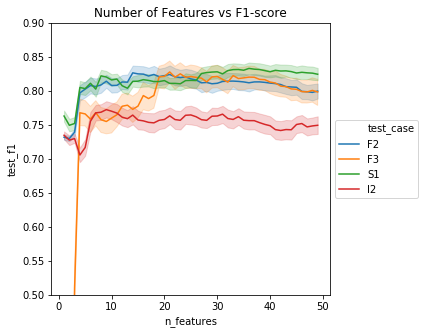

In [40]:
plt.figure(figsize=(5,5))
sns.lineplot(x='n_features',y='test_f1',hue='test_case', data=summary)
plt.ylim([0.5,0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs F1-score')
plt.show()

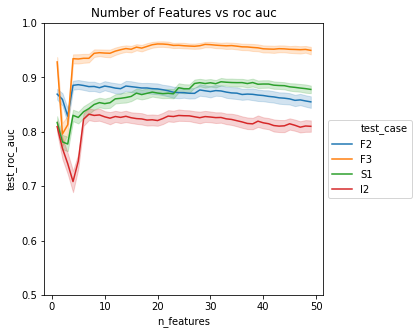

In [41]:
plt.figure(figsize=(5,5))
sns.lineplot(x='n_features',y='test_roc_auc',hue='test_case', data=summary)
plt.ylim([0.5,1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs roc auc')
plt.show()

## Decision tree based feature selection

In [44]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel


def get_features_dt(X, y, dummy):
    
    mask_samples_in_both = X.index.intersection(y.index)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X.loc[mask_samples_in_both], y.loc[mask_samples_in_both])
    clf.feature_importances_  

    indices = np.argsort(clf.feature_importances_)[::-1]
    
    return X.columns[indices]

proteins_selected_f2 = get_features_dt(data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = get_features_dt(data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = get_features_dt(data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = get_features_dt(data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}

decision_tree_feature_selection = os.path.join(DATAFOLDER, 'decision_tree_feature_selection.pkl')

try:
    combind_dt = pd.read_pickle(decision_tree_feature_selection)
except FileNotFoundError:
    summary = []

    for n_features in tqdm(range(1,50)):

        for test_case in test_cases.keys():
            _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']

            _X = data_proteomics[proteins_selected[:n_features]]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]

            result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

            result['name'] = _clf.__class__.__name__
            result['n_features'] = n_features
            result['test_case'] = test_case

            summary.append(pd.DataFrame(result))
    combind_dt = pd.concat(summary)
    combind_dt.to_pickle(decision_tree_feature_selection)

C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\met

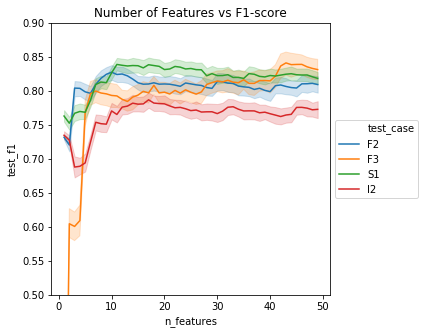

In [26]:
plt.figure(figsize=(5,5))
sns.lineplot(x='n_features',y='test_f1',hue='test_case', data=combind_dt)
plt.ylim([0.5,0.9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs F1-score')
plt.show()

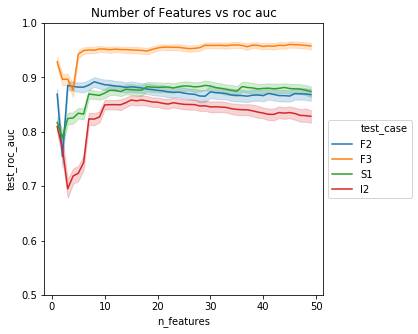

In [27]:
plt.figure(figsize=(5,5))
sns.lineplot(x='n_features',y='test_roc_auc',hue='test_case', data=combind_dt)
plt.ylim([0.5,1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs roc auc')
plt.show()

In [28]:
feature_selected = FeatureSelector(k=5, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')

feature_selected = FeatureSelector(k=20, protein_gene_data=key_ProteinID)
proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')

feature_selected = FeatureSelector(k=32, protein_gene_data=key_ProteinID)
proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')

feature_selected = FeatureSelector(k=7, protein_gene_data=key_ProteinID)
proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}

In [29]:
## Try multiple optimizers and see what happens

from tqdm.notebook import tqdm as tqdm

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

summary = []


for model in tqdm(MLA):

    for test_case in test_cases.keys():
        
        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]
        
        result = cross_validate(model, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)
        result['name'] = model.__class__.__name__
        result['test_case'] = test_case
    
        summary.append(pd.DataFrame(result))
    
print('Complete')

/Users/mstrauss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mstrauss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m


Complete


In [30]:
summary_df = pd.concat(summary)
grouped = summary_df.groupby(['name','test_case']).mean().sort_values(by=['test_case','test_f1'], ascending=False)
grouped = grouped.reset_index()
grouped

grouped_norm = grouped.copy()

for i in range(len(grouped)):
    
    grouped_norm.loc[i, cols] -= baseline[grouped_norm.loc[i,'test_case']][cols]

In [31]:
grouped_norm.sort_values(by='test_f1', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
44,LinearDiscriminantAnalysis,F3,-0.381341,-0.000494,0.033959,0.081228,0.062004,0.044765,0.015793
0,ExtraTreesClassifier,S1,-0.247951,0.018304,0.025826,0.014936,0.020790,0.027339,0.038648
22,LogisticRegressionCV,I2,-0.074140,-0.000164,0.006132,0.005235,0.005173,0.005401,0.009033
66,LinearDiscriminantAnalysis,F2,-0.369304,-0.000411,0.034311,-0.029051,-0.000533,0.011281,0.003146


In [32]:
grouped_norm.sort_values(by='test_roc_auc', ascending=False).groupby('test_case').head(1)

,name,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
1,RandomForestClassifier,S1,-0.218148,0.014644,0.031616,0.001654,0.017014,0.026859,0.046685
46,RidgeClassifierCV,F3,-0.380846,-0.000222,0.039500,0.053158,0.048370,0.032617,0.015922
31,GaussianNB,I2,-0.292360,0.000090,0.058116,-0.079900,-0.019373,0.009141,0.012140
72,SVC,F2,-0.364357,0.000451,0.035064,-0.063282,-0.020455,-0.002740,0.006090


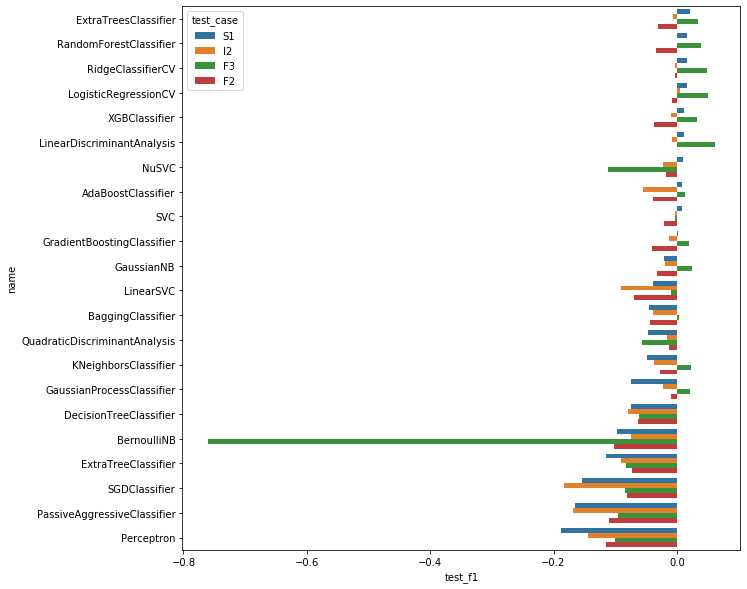

In [33]:
plt.figure(figsize = (10,10))
sns.barplot(x='test_f1', y='name', hue='test_case', data=grouped_norm)
plt.show()

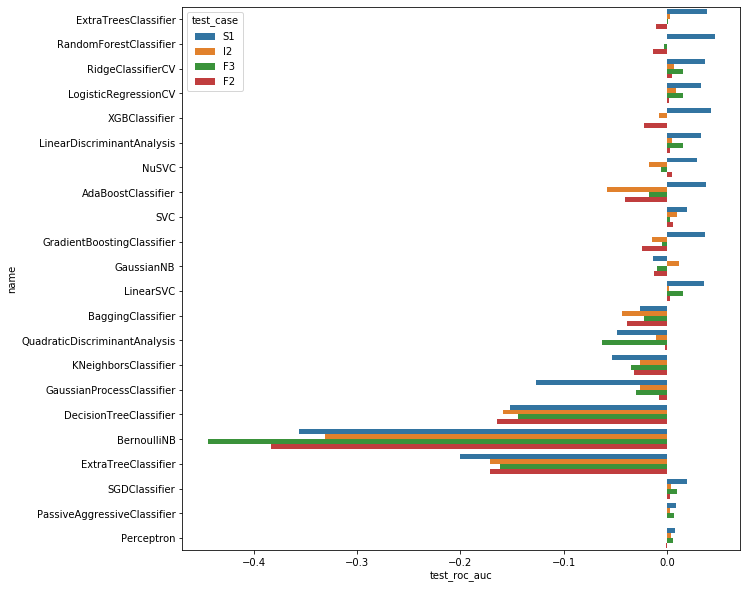

In [34]:
plt.figure(figsize = (10,10))
sns.barplot(x='test_roc_auc', y='name', hue='test_case', data=grouped_norm)
plt.show()

## Missing value imputation ? / Preprocesisng

### CV

In [35]:
from helper import log2, imputation_normal_distribution

summary = []

for CV_COEFFICIENT in tqdm(np.linspace(0.2,0.5,10)):

    DATA_COMPLETENESS = 0.6
    MIN_N_PROTEIN_GROUPS = 200
    #CV_COEFFICIENT = 0.3

    data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
    data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
    data_plasma_filtered_log = data_plasma_filtered.apply(log2)
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)

    qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
    df_qc = data_plasma_filtered.copy()[qc_plasma]
    coef_of_variation = lambda x: np.std(x) / np.mean(x)
    proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

    cv_selected = proteins_cv < CV_COEFFICIENT

    df_qc = df_qc.assign(cv = proteins_cv)
    qc_30 = df_qc[cv_selected].index

    df = data_plasma_filtered_log_imputed.copy()
    df = df.rename_axis('Sample ID', axis=1).T
    # filter proteins for CV < 30% of the inter-day/plate quality assessment 
    df_30 = df[qc_30]
    data_proteomics = df_30

    feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
    proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
    proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
    proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
    proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')
    
    test_cases = {}

    test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
    test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
    test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
    test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}


    for test_case in test_cases.keys():
        _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]

        result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

        result['name'] = _clf.__class__.__name__
        result['CV'] = CV_COEFFICIENT
        result['test_case'] = test_case

        summary.append(pd.DataFrame(result))
        
combined = pd.concat([pd.DataFrame(_).groupby('test_case').mean() for _ in summary])
combined = combined.reset_index()

combined.sort_values(by=['test_case','test_f1'], ascending=False).groupby('test_case').head(3)

,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,CV
6,S1,0.002130,0.005154,0.796570,0.849436,0.821154,0.785148,0.856808,0.233333
10,S1,0.001636,0.003858,0.796570,0.849436,0.821154,0.785148,0.856808,0.266667
14,S1,0.001660,0.003772,0.794839,0.841244,0.816307,0.780740,0.851838,0.300000
7,I2,0.002274,0.005256,0.780870,0.764410,0.770306,0.755103,0.827593,0.233333
11,I2,0.001733,0.004177,0.780870,0.764410,0.770306,0.755103,0.827593,0.266667
15,I2,0.001696,0.003914,0.780870,0.764410,0.770306,0.755103,0.827593,0.300000
1,F3,0.001669,0.003724,0.821301,0.716374,0.760866,0.829697,0.944718,0.200000
5,F3,0.002323,0.004910,0.818404,0.714971,0.760191,0.828995,0.944847,0.233333
9,F3,0.002006,0.004552,0.818404,0.714971,0.760191,0.828995,0.944847,0.266667
0,F2,0.001551,0.003648,0.838568,0.789449,0.811881,0.798525,0.882077,0.200000


* no big difference

In [36]:
from helper import log2, imputation_normal_distribution

summary = []

for DATA_COMPLETENESS in tqdm(np.linspace(0.4,0.8,20)):

    #DATA_COMPLETENESS = 0.6
    MIN_N_PROTEIN_GROUPS = 200
    CV_COEFFICIENT = 0.3

    data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
    data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
    data_plasma_filtered_log = data_plasma_filtered.apply(log2)
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)

    qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
    df_qc = data_plasma_filtered.copy()[qc_plasma]
    coef_of_variation = lambda x: np.std(x) / np.mean(x)
    proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

    cv_selected = proteins_cv < CV_COEFFICIENT

    df_qc = df_qc.assign(cv = proteins_cv)
    qc_30 = df_qc[cv_selected].index

    df = data_plasma_filtered_log_imputed.copy()
    df = df.rename_axis('Sample ID', axis=1).T
    # filter proteins for CV < 30% of the inter-day/plate quality assessment 
    df_30 = df[qc_30]
    data_proteomics = df_30

    feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
    proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
    proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
    proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
    proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')
    
    test_cases = {}

    test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
    test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
    test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
    test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}


    for test_case in test_cases.keys():
        _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]

        result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

        result['name'] = _clf.__class__.__name__
        result['DATA_COMPLETENESS'] = DATA_COMPLETENESS
        result['test_case'] = test_case

        summary.append(pd.DataFrame(result))
        
combined = pd.concat([pd.DataFrame(_).groupby('test_case').mean() for _ in summary])
combined = combined.reset_index()

combined.sort_values(by=['test_case','test_f1'], ascending=False).groupby('test_case').head(3)



,test_case,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,DATA_COMPLETENESS
62,S1,0.001588,0.003686,0.795187,0.856090,0.823510,0.786174,0.853604,0.715789
54,S1,0.001451,0.003414,0.794548,0.856603,0.823403,0.785785,0.853421,0.673684
50,S1,0.001524,0.003626,0.793748,0.856615,0.823018,0.785146,0.853321,0.652632
35,I2,0.001438,0.003443,0.797355,0.775064,0.783689,0.770335,0.831893,0.568421
7,I2,0.001453,0.003440,0.797325,0.772959,0.782607,0.769595,0.831991,0.421053
11,I2,0.001999,0.004669,0.790420,0.761764,0.773689,0.761469,0.835059,0.442105
57,F3,0.001505,0.003394,0.819071,0.717135,0.761747,0.830077,0.945274,0.694737
61,F3,0.001540,0.003404,0.819071,0.717135,0.761747,0.830077,0.945275,0.715789
77,F3,0.001546,0.003426,0.818815,0.716023,0.760959,0.829521,0.945664,0.800000
32,F2,0.001532,0.003545,0.840290,0.804064,0.820295,0.805228,0.880816,0.568421


* this also doesn't change much.

## Scalers 

In [37]:
from helper import log2, imputation_normal_distribution

summary = []

from sklearn.preprocessing import StandardScaler

for imputation in tqdm(['impute_normal','z_scaling','mean']):

    DATA_COMPLETENESS = 0.6
    MIN_N_PROTEIN_GROUPS = 200
    CV_COEFFICIENT = 0.3

    data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
    data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
    data_plasma_filtered_log = data_plasma_filtered.apply(log2)
    
    if imputation == 'impute_normal':
        data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)
        
    elif imputation == 'z_scaling':
        
        scaler = StandardScaler()
        
        data_plasma_filtered_log_imputed_np = scaler.fit_transform(data_plasma_filtered_log.values)
        data_plasma_filtered_log_imputed = data_plasma_filtered_log.copy()
        data_plasma_filtered_log_imputed.loc[:,:] = np.nan_to_num(data_plasma_filtered_log_imputed_np)
        
    elif imputation == 'mean':
        # use the mean of protein group as imputation
        
        data_plasma_filtered_log_imputed = data_plasma_filtered_log.fillna(data_plasma_filtered_log.mean())
        
    qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
    df_qc = data_plasma_filtered.copy()[qc_plasma]
    coef_of_variation = lambda x: np.std(x) / np.mean(x)
    proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

    cv_selected = proteins_cv < CV_COEFFICIENT

    df_qc = df_qc.assign(cv = proteins_cv)
    qc_30 = df_qc[cv_selected].index

    df = data_plasma_filtered_log_imputed.copy()
    df = df.rename_axis('Sample ID', axis=1).T
    # filter proteins for CV < 30% of the inter-day/plate quality assessment 
    df_30 = df[qc_30]
    data_proteomics = df_30

    feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
    proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
    proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
    proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
    proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')
    
    test_cases = {}

    test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
    test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
    test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
    test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}


    for test_case in test_cases.keys():
        _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')

        proteins_selected = test_cases[test_case]['proteins']
        y = test_cases[test_case]['y']

        _X = data_proteomics[proteins_selected.index]
        in_both = y.index.intersection(_X.index)
        _X = _X.loc[in_both]
        _y = y.loc[in_both]

        result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

        result['name'] = _clf.__class__.__name__
        result['imputation'] = imputation
        result['test_case'] = test_case
        
        xx = pd.DataFrame(result).groupby('test_case').mean()
        
        xx['imputation'] = imputation
        
        summary.append(xx)
        

pd.concat(summary).sort_values(by=['test_case','test_f1'], ascending=False).groupby('test_case').head(3)

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc,imputation
test_case,,,,,,,,
S1,0.001534,0.003558,0.794839,0.841244,0.816307,0.780740,0.851838,impute_normal
S1,0.001867,0.004074,0.747523,0.777859,0.760614,0.720446,0.785195,mean
S1,0.001502,0.003627,0.717573,0.779526,0.745200,0.691784,0.763673,z_scaling
I2,0.001401,0.003546,0.802651,0.763812,0.780550,0.771177,0.848849,z_scaling
I2,0.001660,0.004018,0.783284,0.777240,0.778282,0.761774,0.834718,mean
I2,0.001490,0.003595,0.780870,0.764410,0.770306,0.755103,0.827593,impute_normal
F3,0.001422,0.003574,0.889469,0.724737,0.793834,0.845953,0.942435,z_scaling
F3,0.001875,0.003982,0.815496,0.735439,0.770415,0.837719,0.944243,mean
F3,0.001598,0.003636,0.818404,0.714971,0.760191,0.828995,0.944847,impute_normal


* Z-scaling seems to be always better, except for S1

## Hyperparameter Tuning

Check how we could improve the results with hyperparameter tuning, i.e. when using extratrees

In [38]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS = 200
CV_COEFFICIENT = 0.3

data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)

qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

cv_selected = proteins_cv < CV_COEFFICIENT

df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}

scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
CV_FOLDS = 5
CV_REPEATS = 10

_clf  = ensemble.ExtraTreesClassifier()

proteins_selected = proteins_selected_f2
y = kleiner_ge_2

_X = data_proteomics[proteins_selected.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

mean_vals = pd.DataFrame(result).mean().to_frame().T

mean_vals

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
0,0.077612,0.0179,0.85298,0.793462,0.820322,0.809664,0.888727


In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
        'n_estimators': range(10,200,10),
        'max_features': range(0,10,1),
        'min_samples_leaf': range(20,50,5),
        'min_samples_split': range(15,36,5),
        }

folds = 10
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(_X,_y), verbose=3, random_state=1001 )

# Here we go

random_search.fit(_X, _y)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.3s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fc8886f4250>,
                   error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                 

In [40]:
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)

{'mean_fit_time': array([0.07213061, 0.07673442, 0.0084821 , 0.06304474, 0.01785693,
       0.02477698, 0.11610312, 0.09917018, 0.12892601, 0.08970611]), 'std_fit_time': array([0.00583777, 0.00506276, 0.00095557, 0.00163875, 0.00095054,
       0.00112608, 0.00671696, 0.00513547, 0.00646789, 0.00391579]), 'mean_score_time': array([0.00797567, 0.00839019, 0.        , 0.        , 0.00316222,
       0.00375781, 0.01232295, 0.01106827, 0.01481543, 0.0092519 ]), 'std_score_time': array([0.00077705, 0.00044515, 0.        , 0.        , 0.00036965,
       0.00023228, 0.00112795, 0.00144825, 0.0013073 , 0.00078169]), 'param_n_estimators': masked_array(data=[90, 90, 20, 190, 20, 30, 150, 130, 180, 110],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[15, 35, 15, 20, 15, 30, 20, 15, 20, 15],
             mask=[False, False, False, False, False

In [41]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS = 200
CV_COEFFICIENT = 0.3

data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)

qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

cv_selected = proteins_cv < CV_COEFFICIENT

df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30

feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')

test_cases = {}

test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}

scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
CV_FOLDS = 5
CV_REPEATS = 10

_clf  = ensemble.ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=9,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=25, min_samples_split=35,
                     min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

proteins_selected = proteins_selected_f2
y = kleiner_ge_2

_X = data_proteomics[proteins_selected.index]
in_both = y.index.intersection(_X.index)
_X = _X.loc[in_both]
_y = y.loc[in_both]

result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=0) , scoring=scoring)

mean_vals = pd.DataFrame(result).mean().to_frame().T

mean_vals

,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
0,0.067887,0.017009,0.870893,0.783385,0.822992,0.817862,0.890838
